In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
from adabmDCA.fasta_utils import get_tokens
import h5py

import torch
from fef.rbms import fefRBMbin
from annadca.dataset import DatasetBin
from annadca.utils import get_eigenvalues_history
from annadca.plot import plot_PCA

In [2]:
fname_data = "/home/lorenzo/Documents/data/Test/HGD/HGD.dat"
fname_ann = "/home/lorenzo/Documents/data/Test/HGD/HGD_ann_cont.csv"
fname_weights = None
fname_model = "/home/lorenzo/Documents/models/HGD/fef_params.h5"

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [4]:
rbm = fefRBMbin()
rbm.load(fname_model, device=device, dtype=dtype)
dataset = DatasetBin(
    path_data=fname_data,
    path_ann=fname_ann,
    path_weights=fname_weights,
    device=device,
)

data = dataset.data
labels_data_cont = dataset.to_label(dataset.labels_one_hot[:, :5])
temp_labels_pop = dataset.labels_one_hot.clone()
temp_labels_pop[:, :5] = 0
labels_data_pop = dataset.to_label(temp_labels_pop)

Dataset imported: M = 5008, L = 805, M_eff = 5008.


In [5]:
# Sample chains from the model
init_chains = rbm.init_chains(num_samples=len(data))
chains = rbm.sample_conditioned(
    gibbs_steps=10,
    chains=init_chains,
    targets=dataset.labels_one_hot,
)

In [6]:
# project data and chains
_, _, Vt = torch.linalg.svd(data - data.mean(0), full_matrices=False)
data_proj = data @ Vt.T / dataset.get_num_residues()**0.5
chains_proj = chains @ Vt.T / dataset.get_num_residues()**0.5
data_proj = data_proj.cpu().numpy()
chains_proj = chains_proj.cpu().numpy()

In [7]:
# Define the colors
unique_labels_cont = np.unique(labels_data_cont)
cmap = plt.get_cmap("tab10", len(unique_labels_cont))
label_to_color_cont = {label.item(): cmap(i) for i, label in enumerate(unique_labels_cont)}

unique_labels_pop = np.unique(labels_data_pop)
cmap = plt.get_cmap("tab20", len(unique_labels_pop))
label_to_color_pop = {label.item(): cmap(i) for i, label in enumerate(unique_labels_pop)}

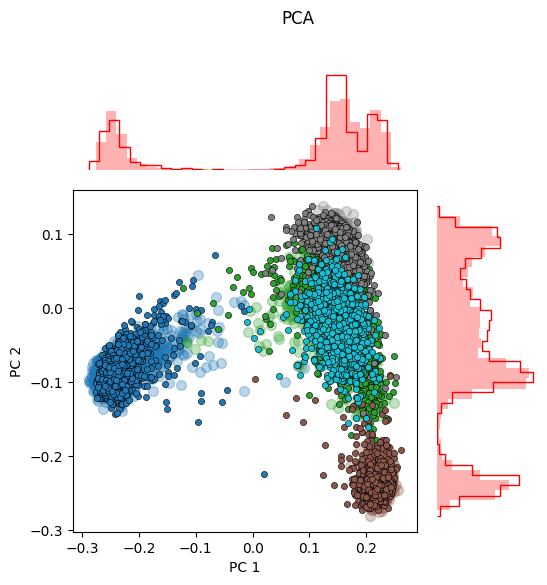

In [8]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data_cont,
    data2=chains_proj,
    labels2=labels_data_cont,
    label_to_color=label_to_color_cont,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=False,
)

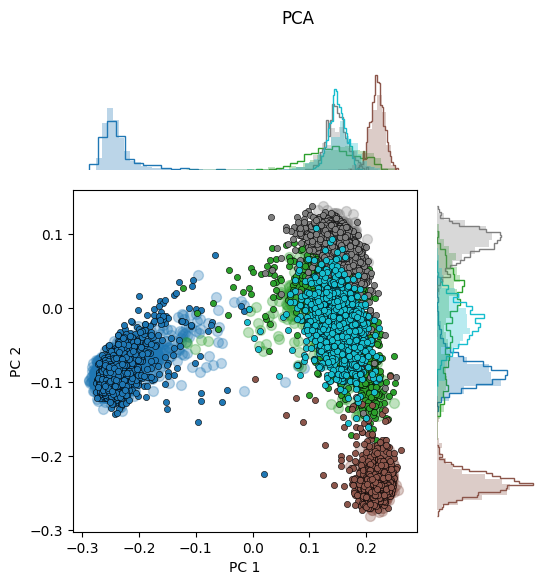

In [9]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data_cont,
    data2=chains_proj,
    labels2=labels_data_cont,
    label_to_color=label_to_color_cont,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)

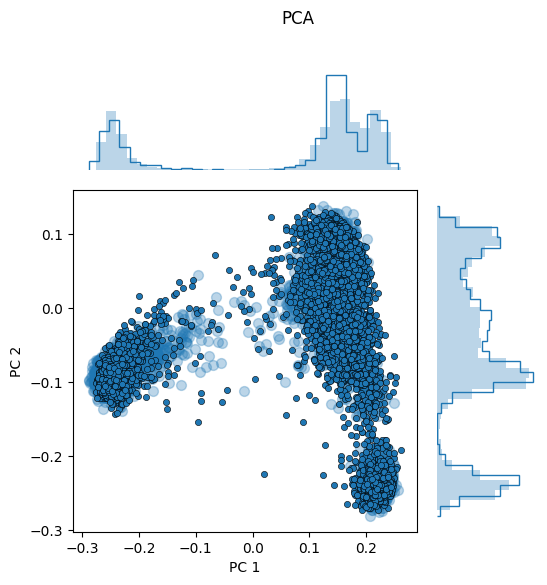

In [10]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data_pop,
    data2=chains_proj,
    labels2=labels_data_pop,
    label_to_color=label_to_color_pop,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)

In [ ]:
# Plot pca of conditioned chains and data but only one label
label_idx = 3
label_idx_pop = label_idx + 5
label = dataset.idx_to_label[label_idx_pop]
mask_data = labels_data_pop == label
data_proj_label = data_proj[mask_data]
chains_proj_label = chains_proj[mask_data]

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj_label,
    labels1=labels_data_pop[mask_data],
    data2=chains_proj_label,
    labels2=labels_data_pop[mask_data],
    label_to_color={label: cmap(label_idx)},
    dim1=0,
    dim2=1,
    title=label,
    split_labels=False,
)

In [13]:
updates, eigenvalues = get_eigenvalues_history(fname_model, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(fname_model, target_matrix="label_matrix", device=device, dtype=dtype)

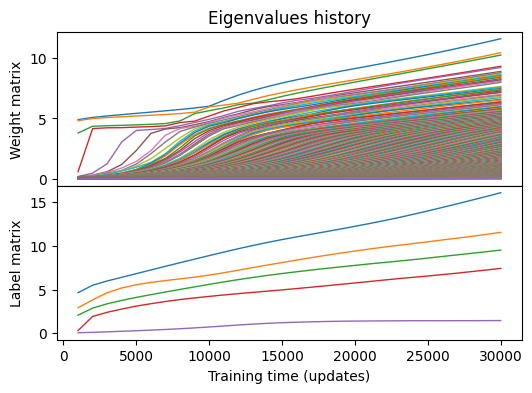

In [14]:

# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix. xaxis is shared and there is no border between the plots
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
#ax[0].set_xscale("log")
#ax[1].set_yscale("log")
#ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues history");

### Predict labels of the data

In [15]:
predictions = rbm.predict_labels(
    gibbs_steps=10000,
    chains=init_chains,
    targets=dataset.data,
)

In [16]:
accuracy_cont = (predictions[:, :5].argmax(-1) == dataset.labels_one_hot[:, :5].argmax(-1)).float().mean().item()
#accuracy_pop = (predictions[:, 5:].argmax(-1) == dataset.labels_one_hot[:, 5:].argmax(-1)).float().mean().item()
print(f"Train accuracy continent: {accuracy_cont:.2f}")
#print(f"Train accuracy population: {accuracy_pop:.2f}")

Train accuracy continent: 0.99


In [17]:
predictions_label = dataset.to_label(predictions)
targets_label = dataset.to_label(dataset.labels_one_hot)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
cm = confusion_matrix(targets_label, predictions_label, normalize="true")

In [20]:
from fef.plot import plot_confusion_matrix

In [35]:
def plot_confusion_matrix(
    filename: str,
    confusion_matrix: np.ndarray,
    checkpoint: int,
    labels: list,
) -> None:
    
    fig, ax = plt.subplots(dpi=192, nrows=1, ncols=1)
    im = ax.imshow(confusion_matrix, cmap='viridis')
    ax.set_title(r'$t_{\mathrm{age}}=$' + str(checkpoint), size=15)
    ax.set_ylabel('True labels', size=15)
    ax.set_xlabel('Predicted labels', size=15)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, rotation=45, ha='right');
    ax.set_xticklabels(labels, rotation=45, ha='right');
    plt.colorbar(im, label="Fraction of data", orientation="vertical")
    plt.show()
    #fig.savefig(filename, bbox_inches='tight')
    plt.close()

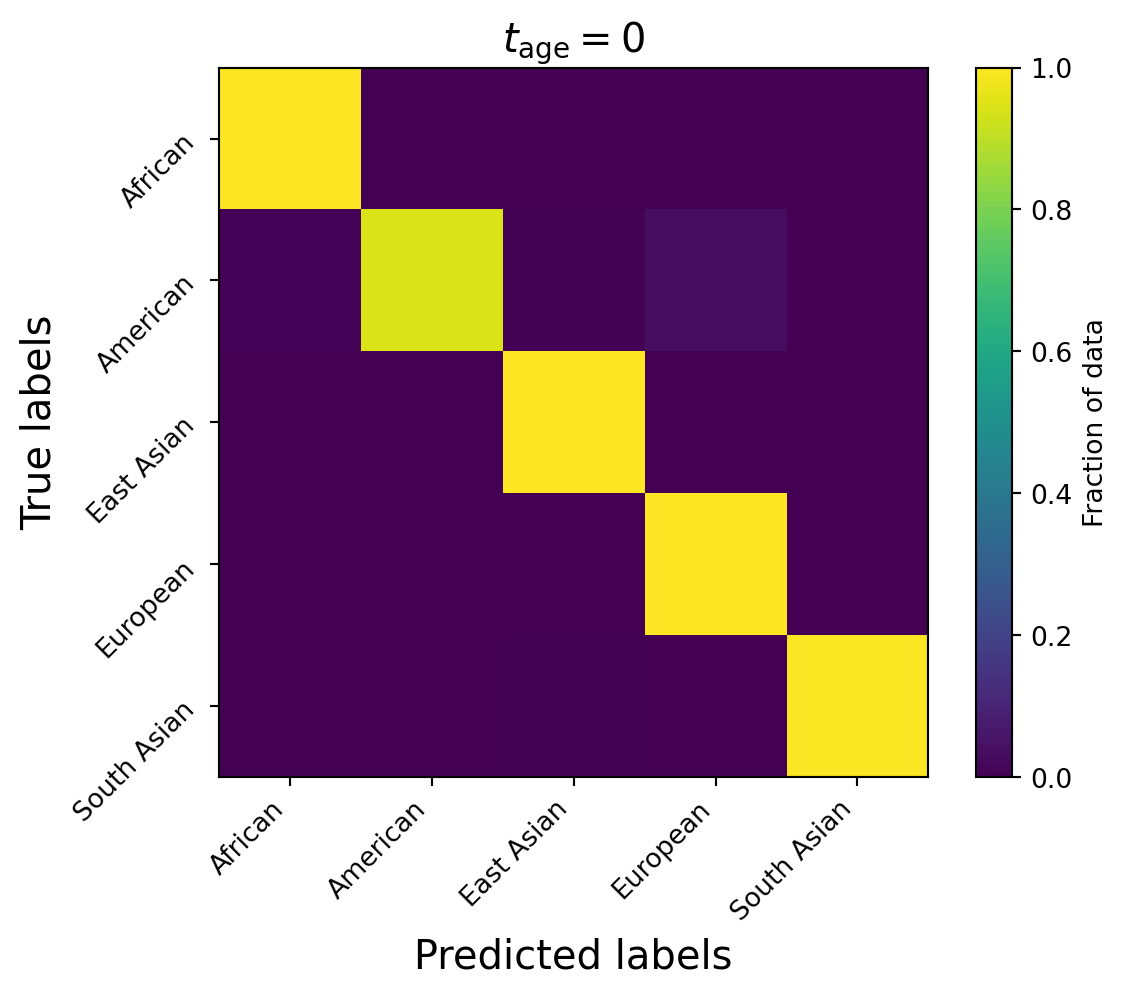

In [36]:
plot_confusion_matrix(
    "cuao",
    confusion_matrix=cm,
    checkpoint=0,
    labels=np.unique(targets_label),
)